In [1]:
#install dependencies
# ! pip install pandas pyarrow matplotlib

In [1]:
import pandas
import matplotlib.pyplot as plt
import json

### Task 1 ###

Merging the three datasets to one.

In [2]:
def open_file(filename: str):
    """
    Helper function to open the file and return a pandas dataframe. Currently accepting files, parquet, json and csv.
    """

    if filename.endswith('.csv'):
        return pandas.read_csv(filename)
    elif filename.endswith('.parquet'):
        return pandas.read_parquet(filename)
    elif filename.endswith('.json'):
        with open(filename, 'r') as file:
            data = json.load(file)
        return pandas.DataFrame(list(data.items()))
    else:
        raise("File extension not permitted")
        
def __merge(customer_filename: str, transaction_filename: str, fraud_filename: str):
    """
    This file takes input customer_filename, transaction_filename and fruad filename and load data into pandas dataframes.
    The function returns a pandas dataframe that merges the data sources indexed by the trans_num and sorted by the `trans_date_trans_time`
    """

    customer_file = open_file(customer_filename)
    transaction_file = open_file(transaction_filename)
    fraud_file = open_file(fraud_filename)
    #rename columns of fraud file
    new_cols = {0: 'trans_num', 1: 'is_fraud'}
    fraud_file = fraud_file.rename(columns = new_cols)

    #first combine transaction details with fraud
    transactions_fraud = pandas.merge(transaction_file, fraud_file, on = 'trans_num')

    #then combine the customer file with the customer details using credit card number
    all_data = pandas.merge(transactions_fraud, customer_file, on = 'cc_num')

    #sort all data based on the transaction date and time.`trans_date_trans_time`.
    #convert transdate trans time to a time object. 
    all_data['trans_date_trans_time'] = pandas.to_datetime(all_data['trans_date_trans_time'])

    #sort by transdate and trans time
    final_data = all_data.sort_values(by='trans_date_trans_time')

    return final_data.set_index('trans_num')

In [3]:
df = __merge('../data_sources/customer_release.csv', '../data_sources/transactions_release.parquet', '../data_sources/fraud_release.json')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1647542 entries, 0b242abb623afc578575680df30655b9 to 1765bb45b3aa3224b4cdcb6e7a96cee3
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   index_x                1647542 non-null  int64         
 1   trans_date_trans_time  1647542 non-null  datetime64[ns]
 2   cc_num                 1647542 non-null  int64         
 3   unix_time              1482674 non-null  float64       
 4   merchant               1482893 non-null  object        
 5   category               1482583 non-null  object        
 6   amt                    1647542 non-null  float64       
 7   merch_lat              1647542 non-null  float64       
 8   merch_long             1647542 non-null  float64       
 9   is_fraud               1482872 non-null  float64       
 10  index_y                1647542 non-null  int64         
 11  first                  1647542 non-nul

In [5]:
#since there are multiple is fraud rows with nan values i will get rid of them
df2 = df[~df['is_fraud'].isna()]

## Task 2 ##

We have four insights from our analysts. 

- The frequency of fraudulent transactions depends on the hour of the day the transaction occurs
- The frequency of fraudulent transactions depends on the day of week the transaction occurs
- The frequency of fraudulent transactions depends the month the transaction occurs
- Fraudulent transactions are likely to occur in quick succession

We will first create new columns with hour, day and month. 

In [6]:
df2['hour_of_trans'] = [x.hour for x in df2['trans_date_trans_time']]
df2['day_of_trans'] = [x.day_name() for x in df2['trans_date_trans_time']]
df2['month_of_trans'] = [x.month_name() for x in df2['trans_date_trans_time']]

/tmp/ipykernel_17369/309709211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['hour_of_trans'] = [x.hour for x in df2['trans_date_trans_time']]
/tmp/ipykernel_17369/309709211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['day_of_trans'] = [x.day_name() for x in df2['trans_date_trans_time']]
/tmp/ipykernel_17369/309709211.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

Looking at the hour of transaction and the fradulant rates. 

In [7]:
hour_count_df = df2.groupby(['hour_of_trans', 'is_fraud'])['is_fraud'].count().unstack(fill_value=0)
hour_count_df['fraud_rate'] = hour_count_df[1] / hour_count_df[0] * 100
hour_count_df

is_fraud,0.0,1.0,fraud_rate
hour_of_trans,,,
0,47360,568,1.199324
1,47894,569,1.188040
2,47526,566,1.190927
3,47648,547,1.148002
4,47337,46,0.097176
5,47625,58,0.121785
6,47757,38,0.079569
7,47664,47,0.098607
8,48063,43,0.089466


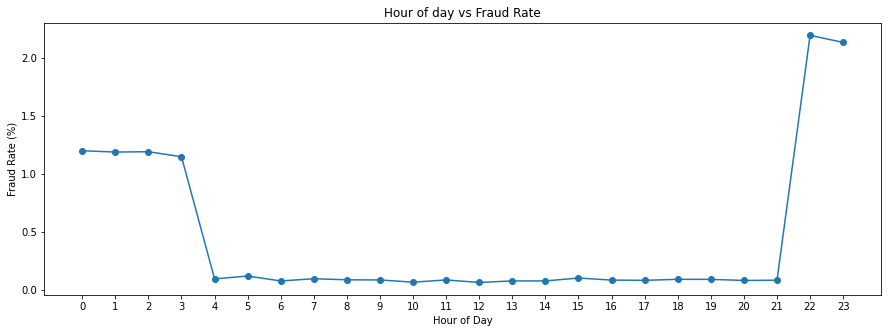

In [8]:
#plot the data
plt.figure(figsize = (15, 5))
plt.title('Hour of day vs Fraud Rate')
plt.plot(hour_count_df.index, hour_count_df['fraud_rate'])
plt.scatter(hour_count_df.index, hour_count_df['fraud_rate'])
plt.xticks(hour_count_df.index)
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate (%)')
plt.show()

Looking at the data you can clearly see that the majority of frauds happen between 9 pm - 3 am. So the analysts are correct about the hour having an impact on the fraud.

Next let's look at the day of the week to see if there is a difference in fraud rate. 

In [9]:
day_count_df = df2.groupby(['day_of_trans', 'is_fraud'])['is_fraud'].count().unstack(fill_value=0)
day_count_df['fraud_rate'] = day_count_df[1] / day_count_df[0] * 100

# Define the new order for days of the week
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert the index to a categorical type with the specified order
day_count_df.index = pandas.Categorical(day_count_df.index, categories=ordered_days, ordered=True)

day_count_df = day_count_df.sort_index()

day_count_df

is_fraud,0.0,1.0,fraud_rate
Monday,294972,1034,0.350542
Tuesday,216037,873,0.404097
Wednesday,146338,778,0.531646
Thursday,164735,916,0.556045
Friday,171065,899,0.525531
Saturday,209660,948,0.452161
Sunday,273569,1048,0.383084


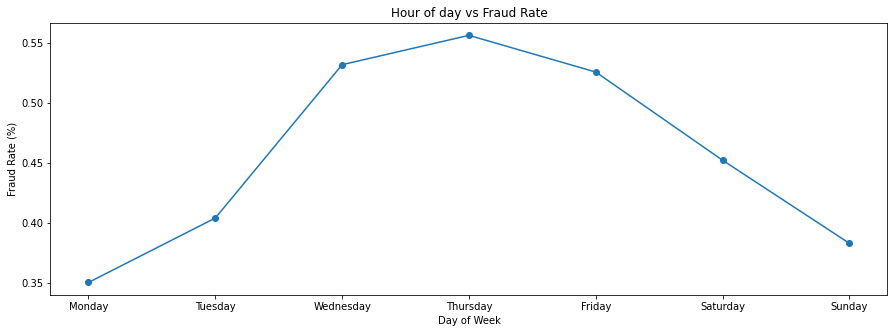

In [10]:
#plot the data
plt.figure(figsize = (15, 5))
plt.title('Hour of day vs Fraud Rate')
plt.plot(day_count_df.index, day_count_df['fraud_rate'])
plt.scatter(day_count_df.index, day_count_df['fraud_rate'])
plt.xticks(day_count_df.index)
plt.xlabel('Day of Week')
plt.ylabel('Fraud Rate (%)')
plt.show()

Looking at the data, the day of the week don't seem to have a huge impact as the hour of the day. However, you could see that there's less fraud at the begining of the week and it increases during the middle of the week and subsides during approaching the weekend. 

Next let's look at the month and its impact on fraud. 

In [11]:
month_count_df = df2.groupby(['month_of_trans', 'is_fraud'])['is_fraud'].count().unstack(fill_value=0)
month_count_df['fraud_rate'] = month_count_df[1] / month_count_df[0] * 100
month_count_df

# Define the new order for Months
ordered_month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Convert the index to a categorical type with the specified order
month_count_df.index = pandas.Categorical(month_count_df.index, categories=ordered_month, ordered=True)

month_count_df = month_count_df.sort_index()

month_count_df

is_fraud,0.0,1.0,fraud_rate
January,83526,540,0.646505
February,77682,560,0.720888
March,114379,581,0.507960
April,107475,433,0.402884
May,116771,671,0.574629
June,138502,549,0.396384
July,137919,449,0.325553
August,140388,581,0.413853
September,111831,501,0.447997
October,110003,555,0.504532


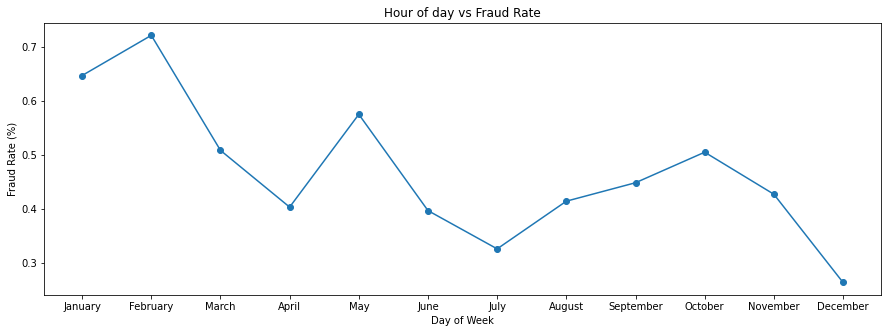

In [12]:
#plot the data
plt.figure(figsize = (15, 5))
plt.title('Hour of day vs Fraud Rate')
plt.plot(month_count_df.index, month_count_df['fraud_rate'])
plt.scatter(month_count_df.index, month_count_df['fraud_rate'])
plt.xticks(month_count_df.index)
plt.xlabel('Day of Week')
plt.ylabel('Fraud Rate (%)')
plt.show()

Month analysis says there's a higher fraud rate at the begining of the yar and it subsides. January, February seems to have the highest fraud rates. 

Next let's look at the transaction time to see if the transactions occured in quick succession. In order to do this let's find the difference between the two transactions.

In [13]:
df2['trans_diff'] = df2['trans_date_trans_time'].diff().dt.total_seconds()

#identify the data that had the previous transacttion and the current transaction false and isolate that data
quick_suc = df2[(df2['is_fraud'] == 1) & (df2['is_fraud'].shift(1) == 1)]

#get the other data that were not fraud
other_suc = df2[(df2['is_fraud'] == 0) & (df2['is_fraud'].shift(1) == 0)]

/tmp/ipykernel_17369/1574113637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['trans_diff'] = df2['trans_date_trans_time'].diff().dt.total_seconds()


In [19]:
print("No fraud transaction successor times.")
print(other_suc['trans_diff'].describe())

print("Fraud transaction successor times.")
print(quick_suc['trans_diff'].describe())

No fraud transaction successor times.
count    1.470030e+06
mean     4.255470e+01
std      8.768363e+01
min      0.000000e+00
25%      1.000000e+01
50%      2.600000e+01
75%      5.600000e+01
max      8.655500e+04
Name: trans_diff, dtype: float64
Fraud transaction successor times.
count    151.000000
mean      50.476821
std       64.214623
min        0.000000
25%        9.500000
50%       26.000000
75%       74.500000
max      456.000000
Name: trans_diff, dtype: float64


Looking at the data, on the contrary to what the analyst says, it seems like the no fraud transactions seem to be quicker than the fraud transactions. The Fraud transactions that were close to each other had a mean time greater than the regular transactions. Also the standard deviation of the fraud transactions is higher. So looking at the data summary, the fraud transactions seem to take longer than the regular transactions.

Next let's look at the transaction amount to see if there's a significant difference between amount of fraud transactions and regular transactions.

is_fraud
0.0     67.637853
1.0    516.428608
Name: amt, dtype: float64


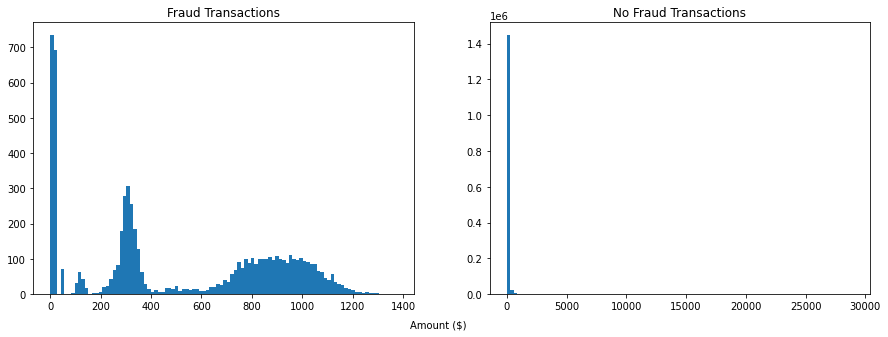

In [38]:
#let's look at the amount of transaction and fraud.
print(df2.groupby('is_fraud')['amt'].mean())

#let's plot them 
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].hist(df2[df2['is_fraud'] == 1]['amt'], bins = 100)
ax[0].set_title('Fraud Transactions')

ax[1].hist(df2[df2['is_fraud'] == 0]['amt'], bins = 100)
ax[1].set_title('No Fraud Transactions')

# Set a common x-axis label for the entire figure
fig.text(0.5, 0.04, 'Amount ($)', ha='center', va='center')
plt.show()

The fraud transaction amount vary widely. Also the mean transaction amount for fraud is higher (516) than the no fraud transaction amount. Most of the non fraud transaction amounts tend to be very small and there are a couple very large ones. 

Finally let's look at the fraud rate of different categories to see if we can find any differences. 

In [52]:
cat_count_df = df2.groupby(['category', 'is_fraud'])['is_fraud'].count().unstack(fill_value=0)
cat_count_df['fraud_rate'] = cat_count_df[1] / cat_count_df[0] * 100

cat_count_df

is_fraud,0.0,1.0,fraud_rate
category,,,
ENTERTAINMENT,47724,97,0.203252
FOOD_DINING,47150,68,0.144221
GAS_TRANSPORT,67382,229,0.339853
GROCERY_NET,23475,57,0.242812
GROCERY_POS,62414,644,1.031820
HEALTH_FITNESS,43848,65,0.148239
HOME,63107,106,0.167969
KIDS_PETS,58463,109,0.186443
MISC_NET,32240,331,1.026675


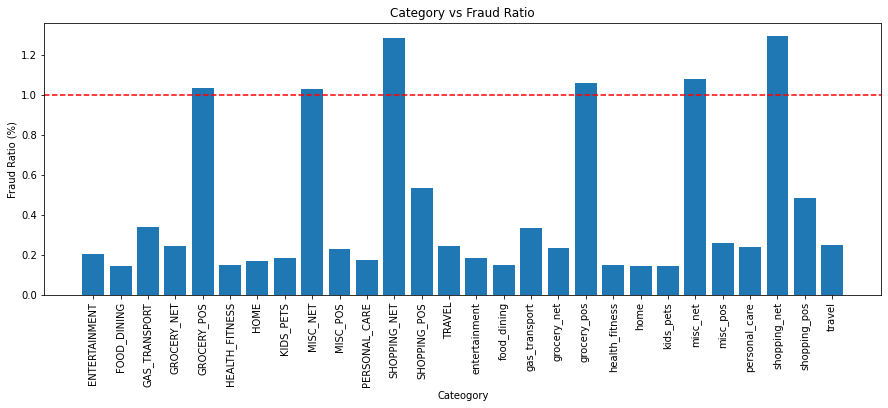

In [64]:
plt.figure(figsize = (15, 5))
plt.bar(cat_count_df.index, height = cat_count_df['fraud_rate'])
plt.xticks(cat_count_df.index, rotation = 90)
plt.axhline(y = 1, linestyle = '--', c = 'r')
plt.xlabel('Cateogory')
plt.ylabel('Fraud Ratio (%)')
plt.title("Category vs Fraud Ratio")
plt.show()

We can see that the categories that are more than 1% of frauds (red dashed line) are all either grocery shopping or internet (NET) purchases. 